# Measurements with the EL1002 and an external power supply

The [EL1002 electronic load](https://zahner.de/products-details/electronic-loads/el1002) can perform measurements over two quadrants by connecting a power supply to the EXT terminal. 
This means that measurements can be made on the OCP/OCV, batteries can be charged/discharged or electrolysers can be investigated, which would not be possible with a conventional electronic load.

The exact wiring must be read in the [EL1002 manual](https://doc.zahner.de/hardware/el1002.pdf). The following figure shows the example connection.

![EL1002 with Supply](EL1002_Supply.png "EL1002 with Supply")

For this example, an EIS measurement with the EL1002 and the power supply [Delta Elektronika SM3300 SM 18-220](https://www.delta-elektronika.nl/en/products/dc-power-supplies-3300w-sm3300-series.html) is controlled with Python. The [Remote2](https://doc.zahner.de/manuals/remote2.pdf) is used to control the EL1002. The Delta supply is controlled with [SCPI over TCP/IP](https://www.delta-elektronika.nl/upload/MANUAL_ETHERNET_AND_SEQUENCER_PROGRAMMING_SM3300_P0157_V201908.pdf), [classes for simplifying the control](https://doc.zahner.de/thales_remote/delta_elektronika_supply/index.html) have been implemented for this purpose.

A 200 Ah lithium cell is connected to the system as measurement object, which is measured at the OCP/OCV.

In [1]:
import sys
import time

from delta_remote.connection import DeltaConnection
from delta_remote.script_wrapper import DeltaSCPIWrapper,DeltaSources

from thales_remote.connection import ThalesRemoteConnection
from thales_remote.script_wrapper import PotentiostatMode,ThalesRemoteScriptWrapper
from thales_remote.file_interface import ThalesFileInterface
from zahner_analysis.file_import.ism_import import IsmImport

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter

# Connect Python to the already launched Thales-Software

A [Remote2](https://doc.zahner.de/manuals/remote2.pdf) connection is established to control the device and a connection is established to exchange the measurement data as explained in [FileExchangeEIS.ipynb](https://github.com/Zahner-elektrik/Thales-Remote-Python/blob/main/Examples/FileExchangeEIS/FileExchangeEIS.ipynb).

In [ ]:
if __name__ == "__main__":
    zenniumConnection = ThalesRemoteConnection()
    zenniumConnection.connectToTerm("localhost")
    
    zahnerZennium = ThalesRemoteScriptWrapper(zenniumConnection)
    zahnerZennium.forceThalesIntoRemoteScript()
    zahnerZennium.calibrateOffsets()
    
    fileInterface = ThalesFileInterface("localhost")
    fileInterface.enableKeepReceivedFilesInObject()
    fileInterface.enableAutomaticFileExchange()

# Connect Python to the Delta Elektronika power supply

For the Delta Elektronika supply, as for the Thales, a class was developed that manages the connection ([DeltaConnection](https://doc.zahner.de/thales_remote/delta_elektronika_supply/index.html#delta_remote.connection.DeltaConnection)), and a class that contains the commands ([DeltaSCPIWrapper](https://doc.zahner.de/thales_remote/delta_elektronika_supply/index.html#delta_remote.script_wrapper.DeltaSCPIWrapper)).

In [ ]:
    deltaConnection = DeltaConnection()
    deltaConnection.connect(ip = "192.168.2.73", port = 8462)
    
    deltaSM18_220 = DeltaSCPIWrapper(deltaConnection)
    
    print(f"IDN:\t{deltaSM18_220.IDN()}")

IDN:	DELTA ELEKTRONIKA BV,SM18-220,000010338779,H0_P0160,0


After the connection is established and the device identification is displayed, the current and voltage source of the Delta supply is switched to Ethernet.

In [ ]:
    deltaSM18_220.setProgSourceVoltage(DeltaSources.eth)
    deltaSM18_220.setProgSourceCurrent(DeltaSources.eth)

# Parameterization of the EIS measurement

The EIS measurement is configured the same way as for spectra with the internal potentiostat. Only potentiostat one is selected, this corresponds to EPC channel one to which the EL1002 is connected.

In [ ]:
    zahnerZennium.setEISOutputPath(r"C:\THALES\temp")
    zahnerZennium.setEISNaming("individual")
    zahnerZennium.setEISOutputFileName("spectra_5aac")
    
    zahnerZennium.selectPotentiostat(1)
    zahnerZennium.setPotentiostatMode(PotentiostatMode.POTMODE_GALVANOSTATIC)
    zahnerZennium.setAmplitude(0)
    zahnerZennium.setLowerFrequencyLimit(0.01)
    zahnerZennium.setStartFrequency(1000)
    zahnerZennium.setUpperFrequencyLimit(100000)
    zahnerZennium.setLowerNumberOfPeriods(5)
    zahnerZennium.setLowerStepsPerDecade(5)
    zahnerZennium.setUpperNumberOfPeriods(10)
    zahnerZennium.setUpperStepsPerDecade(10)
    zahnerZennium.setScanDirection("startToMax")
    zahnerZennium.setScanStrategy("single")

# Switching ON the outputs

After the EIS measurement has been configured, the outputs of the EL1002 and the Delta supply are switched on in the **correct order**.

The EIS measurement should be performed at the OCP. Therefore the EL1002 is switched on at 0 A, afterwards the supply is switched on at 20 A constant current. Then the complete current flows through the EL1002, that no current flows through the object. The supply voltage is set to 6 V, but this voltage will not be reached.

For safety, that everything is settled and stable, a pause of one second is always kept after switching on.

In [ ]:
    zahnerZennium.setCurrent(0)
    zahnerZennium.enablePotentiostat()
    
    time.sleep(1.0)
    
    deltaSM18_220.setTargetVoltage(6)
    deltaSM18_220.setTargetCurrent(20)
    deltaSM18_220.enableOutput()
    
    time.sleep(1)

As a next step, the currents in the system are output to show where which currents flow when the EXT connection is used.

It can be seen that the EL1002 measures 0 A of current through the object even though 20 A of current is output from the supply. These 20 A flow into the output stage of the EL1002, but not through the measuring object and the current measuring unit.

**The 65 watts of power are converted into heat in the EL1002. This is the special aspect of the connection of the EL1002 with the EXT terminal, although the EL1002 displays 0 A current, there is a power loss at the EL1002.**

In [ ]:
    print(f"Measured current\tEL1002:\t\t{zahnerZennium.getCurrent():>10.3f} A")
        
    print(f"Measured current\tDelta SM18-220:\t{deltaSM18_220.getMeasuredCurrent():>10.3f} A")
    print(f"Measured voltage\tDelta SM18-220:\t{deltaSM18_220.getMeasuredVoltage():>10.3f} V")
    print(f"Measured power\t\tDelta SM18-220:\t{deltaSM18_220.getMeasuredPower():>10.3f} W")

Measured current	EL1002:		    -0.009 A
Measured current	Delta SM18-220:	    19.988 A
Measured voltage	Delta SM18-220:	     3.280 V
Measured power		Delta SM18-220:	    65.230 W


# Performing the measurement

After the outputs are turned on, the amplitude is also turned on and the impedance measurement is started. The amplitude must be switched off again after the impedance measurement.

Here 20 A quiescent current was selected by the EL1002 and 5 A amplitude. This ratio must be determined empirically. At least the amplitude must be used as quiescent current, but it is recommended to use more current, a good guideline is factor 3.

In [ ]:
    zahnerZennium.setAmplitude(5)
    zahnerZennium.measureEIS()
    zahnerZennium.setAmplitude(0)

# Switching OFF the outputs

After the measurement, it is necessary to switch off in the reverse order. Since 0 A should flow through the object, the Delta power supply is switched off first, then the EL1002 regulates to 0 A. At last the EL1002 is switched off.

In [ ]:
    deltaSM18_220.disableOutput()
    
    time.sleep(1)
    
    zahnerZennium.disablePotentiostat()

# Plotting the measurement data

The measurement data is plotted after the measurement with matplotlib.

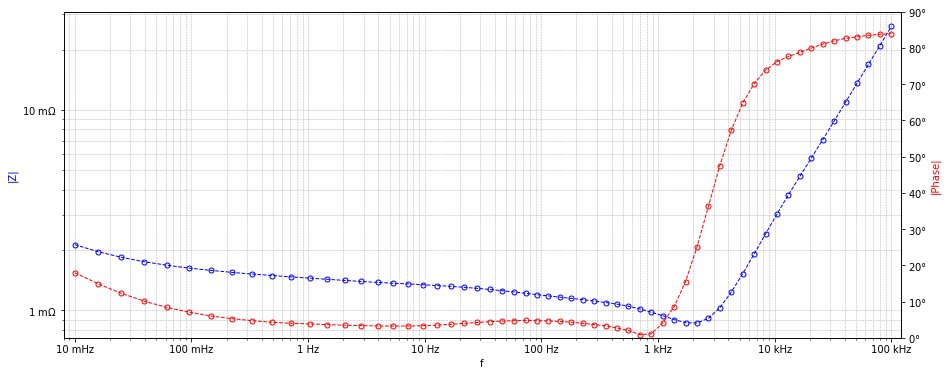

In [3]:
    ismFile = IsmImport(fileInterface.getLatestReceivedFile().binaryData)

    impedanceFrequencies = ismFile.getFrequencyArray()
    impedanceAbsolute = ismFile.getImpedanceArray()
    impedancePhase = ismFile.getPhaseArray()
    impedanceComplex = ismFile.getComplexImpedanceArray()
    
    figBode, (impedanceAxis) = plt.subplots(1, 1)
    
    phaseAxis = impedanceAxis.twinx()
    
    impedanceAxis.loglog(impedanceFrequencies, impedanceAbsolute, linestyle='dashed', linewidth=1, marker="o", markersize=5, fillstyle = "none", color = "blue")
    impedanceAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    impedanceAxis.yaxis.set_major_formatter(EngFormatter(unit="$\Omega$"))
    impedanceAxis.set_xlabel(r"f")
    impedanceAxis.set_ylabel(r"|Z|")
    impedanceAxis.yaxis.label.set_color("blue")
    impedanceAxis.grid(which="both", linestyle="dashed", linewidth=0.5)
    impedanceAxis.set_xlim([min(impedanceFrequencies)*0.8, max(impedanceFrequencies)*1.2])
    
    phaseAxis.semilogx(impedanceFrequencies, np.abs(impedancePhase * (360 / (2 * np.pi))), linestyle='dashed', linewidth=1, marker="o", markersize=5, fillstyle = "none", color = "red")
    phaseAxis.yaxis.set_major_formatter(EngFormatter(unit="$°$", sep=""))
    phaseAxis.xaxis.set_major_formatter(EngFormatter(unit="Hz"))
    phaseAxis.set_xlabel(r"f")
    phaseAxis.set_ylabel(r"|Phase|")
    phaseAxis.yaxis.label.set_color("red")
    phaseAxis.set_ylim([0, 90])
    figBode.set_size_inches(15, 6)
    plt.show()

# Close the connections

Finally, the two connections are disconnected.

In [ ]:
    zahnerZennium.selectPotentiostat(0)
    zenniumConnection.disconnectFromTerm()
    fileInterface.close()

On the Delta source, the signal source for current and voltage is reset to the rotary switch on the front panel before disconnect.

In [ ]:
    deltaSM18_220.setProgSourceVoltage(DeltaSources.front)
    deltaSM18_220.setProgSourceCurrent(DeltaSources.front)
    deltaConnection.disconnect()
    
    print("finish")

finish
